## 0.0 Imports

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import math
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gds
import xgboost as xgb
import random

from boruta                import BorutaPy
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

### 0.2 Loading Data

In [3]:
df_sales = pd.read_csv( 'Data/train.csv', low_memory=False)
df_store = pd.read_csv( 'Data/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales, df_store, how='left', on='Store')

## 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecasa = lambda x: inflection.underscore(x)

cols_new = list(map( snakecasa, cols_old))

# rename 
df1.columns = cols_new

### 1.2 Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


### 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [9]:
#competition_distance            
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)              
#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)   
#promo_interval   
month_map = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)               

### 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical

In [11]:
num_att = df1.select_dtypes( include=['int64', 'float64'])
cat_att = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_att.apply(np.mean)).T
ct2 = pd.DataFrame( num_att.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_att.apply(np.std)).T
d2 = pd.DataFrame( num_att.apply( min)).T
d3 = pd.DataFrame( num_att.apply( max )).T
d4 = pd.DataFrame( num_att.apply( lambda x: x.max()- x.min())).T
d5 = pd.DataFrame( num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_att.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [13]:
num_att.agg(['mean', 'median', 'std', 'min', 'max', 'skew', 'kurtosis']).T

,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


#### 1.7.2 Category Attributes


<AxesSubplot:xlabel='assortment', ylabel='sales'>

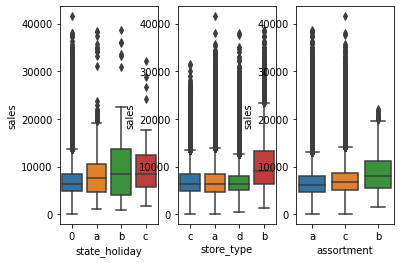

In [14]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

## 2.0 Passo 2 - Feature Engineering

In [15]:
df2 = df1.copy()

### 2.0 Mapa Mental de Hipóteses

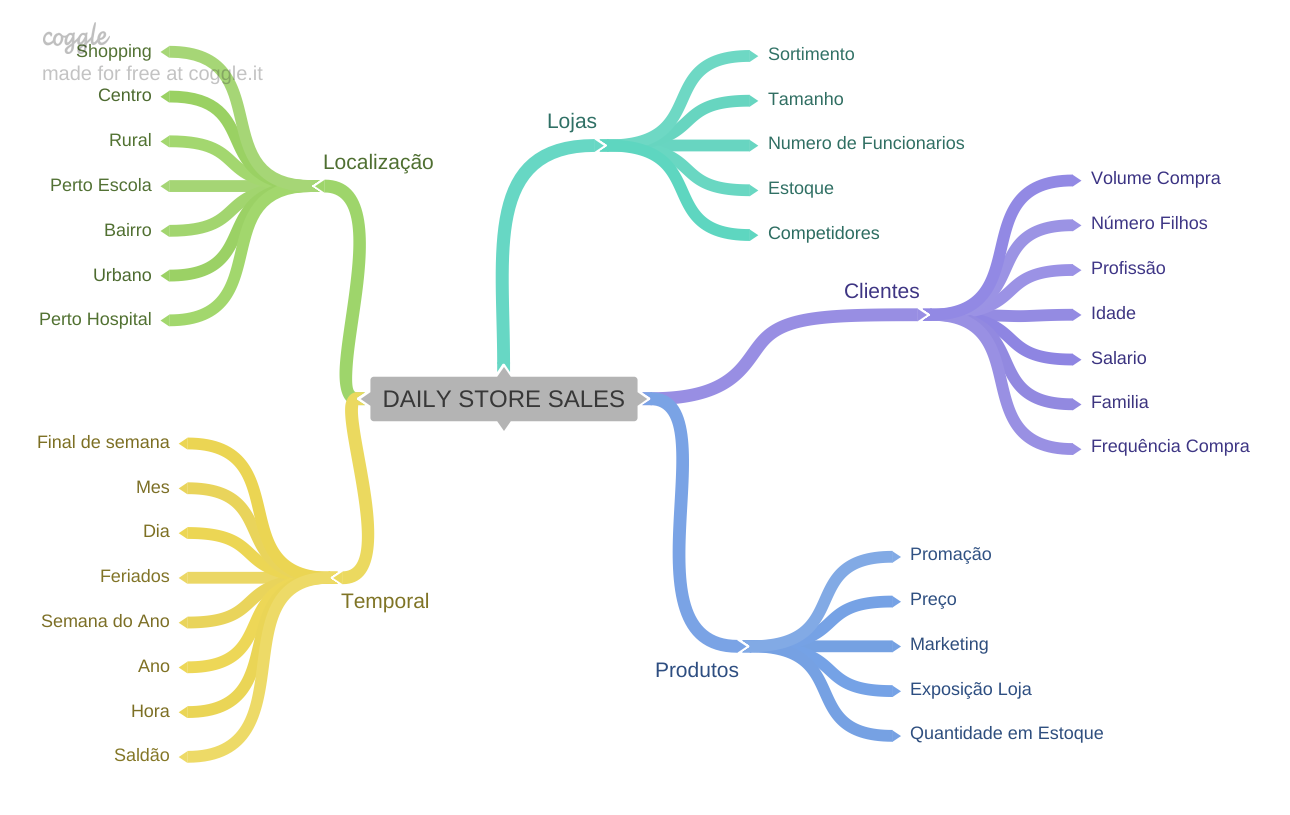

In [16]:
Image( 'img/MindMapHypothesis.png')

### 2.1 Criação das Hipóteses

#### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

#### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.


#### 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem no fim de semana deveriam vender mais.

### 2.0 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com comppetidores á mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 cada mês.

**11.** Lojas deveriam vender menos aos finais da semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering

In [17]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

/tmp/ipykernel_681/2807885499.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


## 3.0 Passo 3 - Filtragem de dados

In [18]:
df3 = df2.copy()

#### 3.1 Filtragem de linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

#### 3.2 Seleção de Colunas

In [20]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 4.0 Passo 04 - Análise Exploratoria de Dados

In [21]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Response Variable

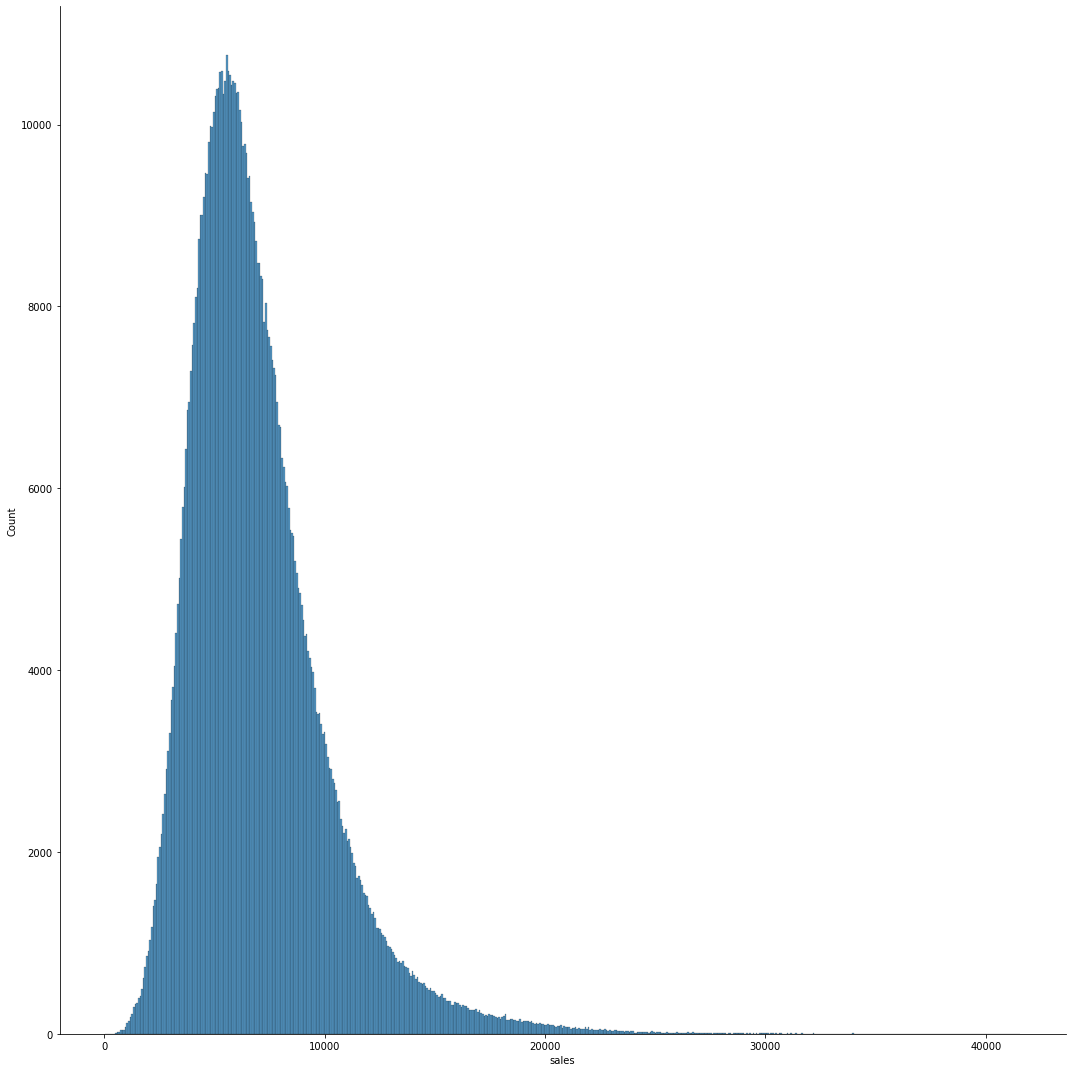

In [22]:
sns.displot(df4['sales'], height=15);

#### 4.1.1 Numerical Variable

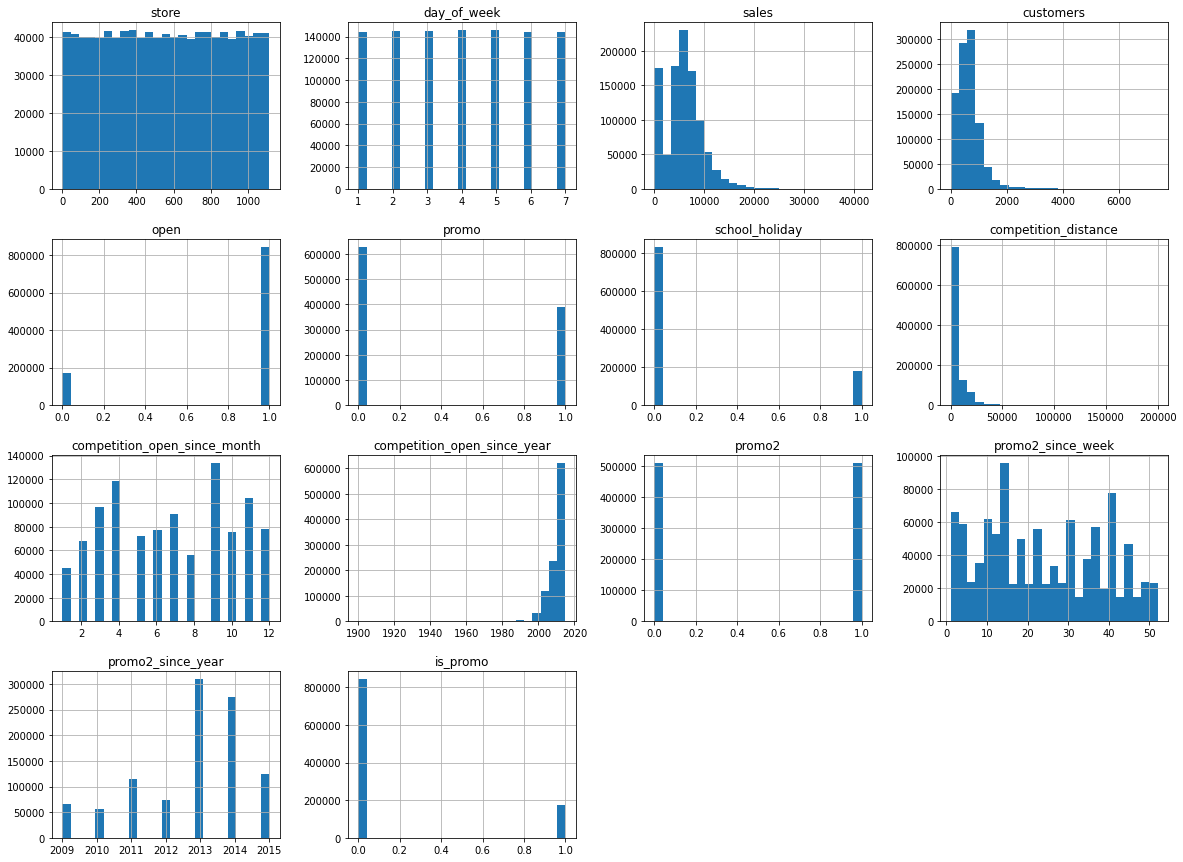

In [23]:
num_att.hist(bins=25, figsize=(20,15));

#### 4.1.1 Categorical Variable

In [24]:
cat_att.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


/home/ericpetterson/.pyenv/versions/3.10.4/envs/DsProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ericpetterson/.pyenv/versions/3.10.4/envs/DsProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ericpetterson/.pyenv/versions/3.10.4/envs/DsProducao/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing oth

<AxesSubplot:xlabel='sales', ylabel='Density'>

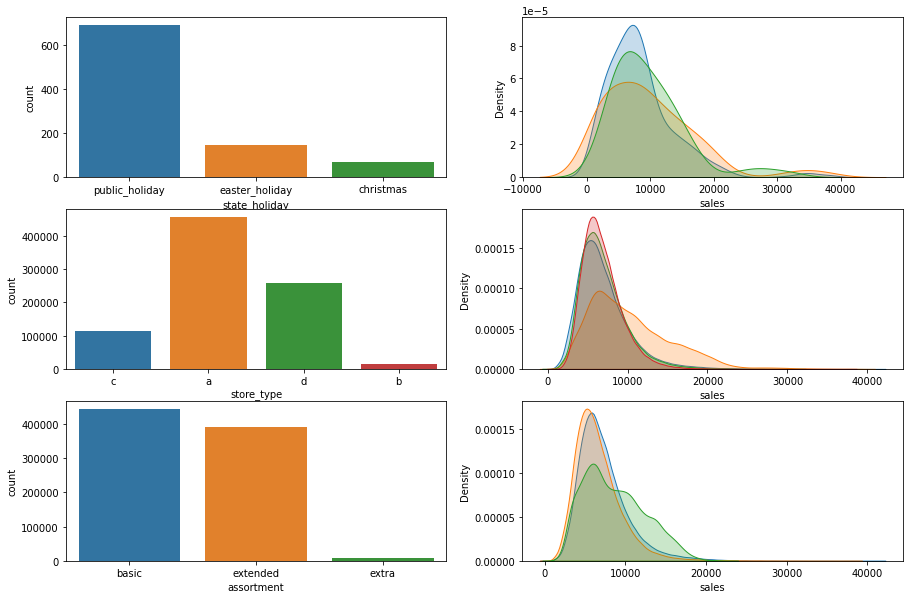

In [25]:
plt.figure(figsize=(15,10));
# State_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# Store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


### 4.2 Análise Bivariada

#### **H1.** Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos

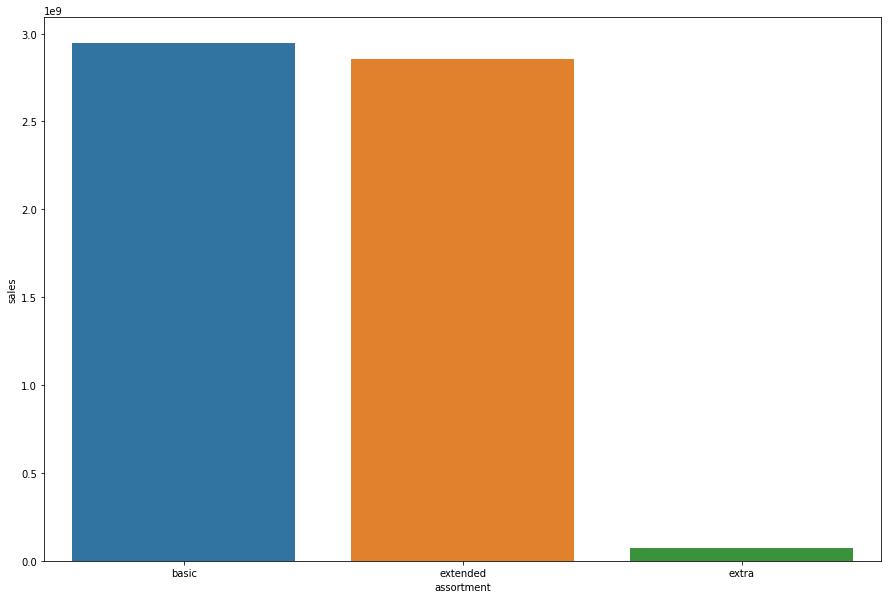

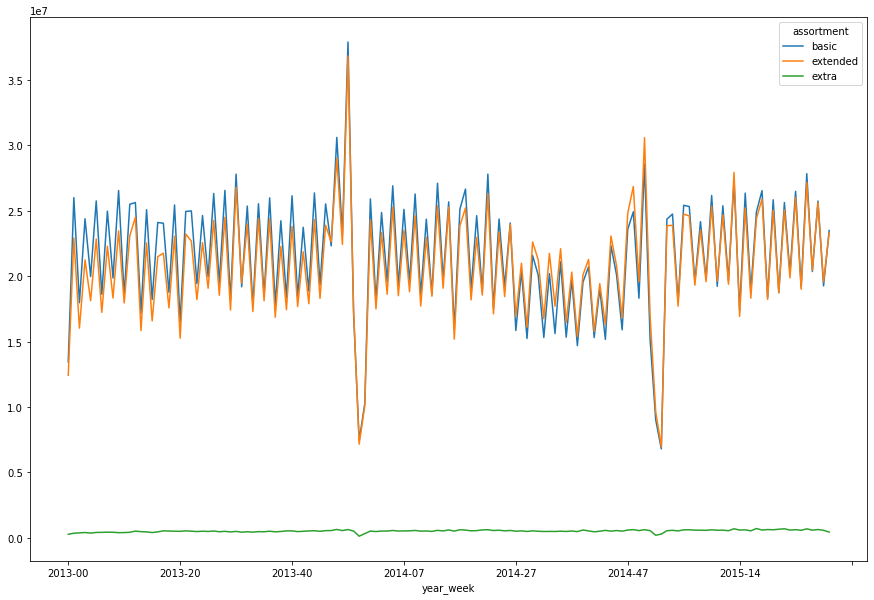

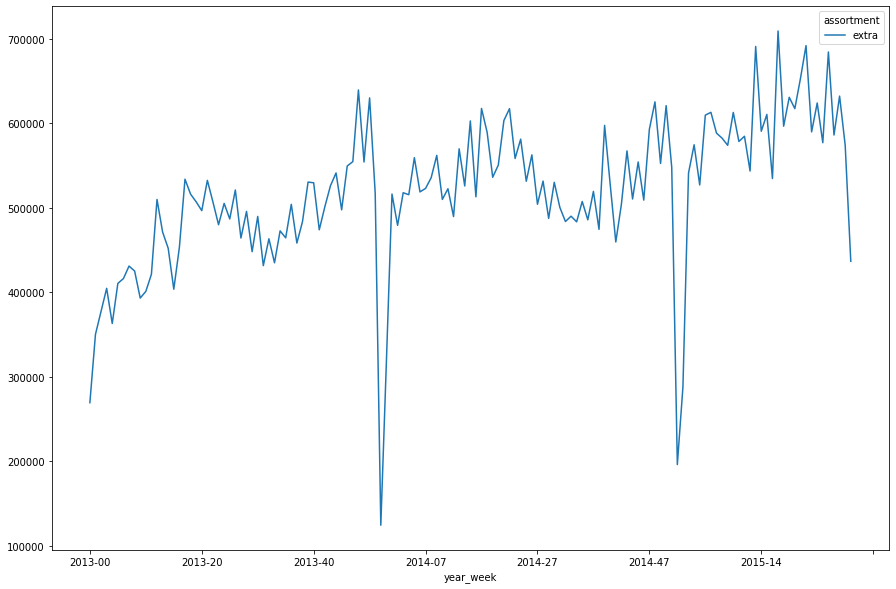

In [26]:
plt.figure(figsize=(15,10));
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10));

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(15,10));

#### **H2.** Lojas com competidores mais proximos deveriam vender menos.
**FALSA** Lojas com competidores mais proximos vendem MAIS

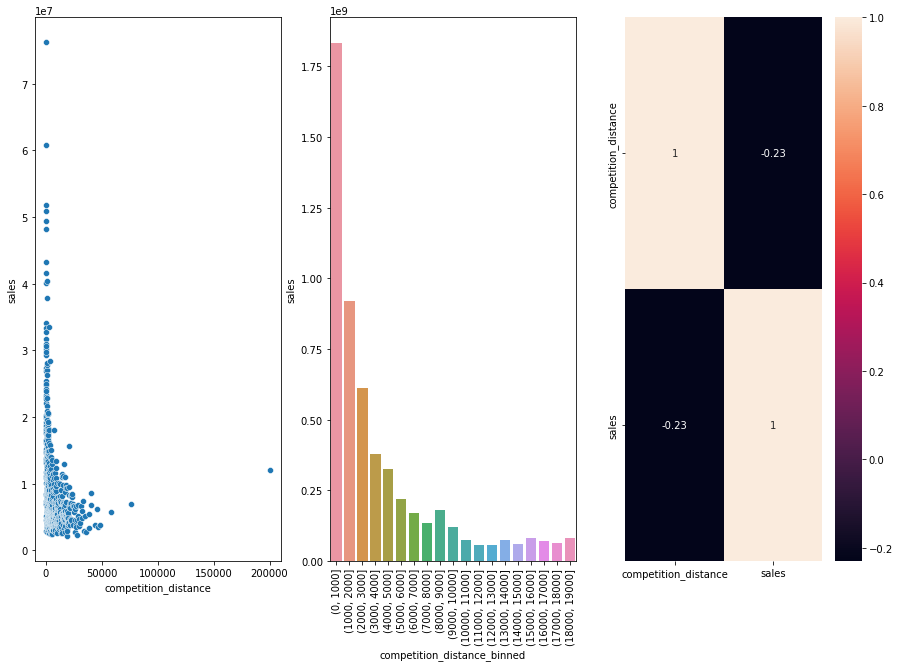

In [27]:
aux4 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(15,10));

plt.subplot( 1,3,1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux4)

plt.subplot( 1,3,2 )
bins = list( np.arange(0, 20000, 1000))
aux4['competition_distance_binned'] = pd.cut(aux4['competition_distance'], bins=bins)
aux5 = aux4[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux5);
plt.xticks( rotation = 90);

plt.subplot( 1,3,3 )
sns.heatmap( aux4.corr(method='pearson'), annot=True);




#### **H3.** Lojas com comppetidores á mais tempo deveriam vender mais.
**FALSE** Lojas com competidores a mais tempo vendem MENOS

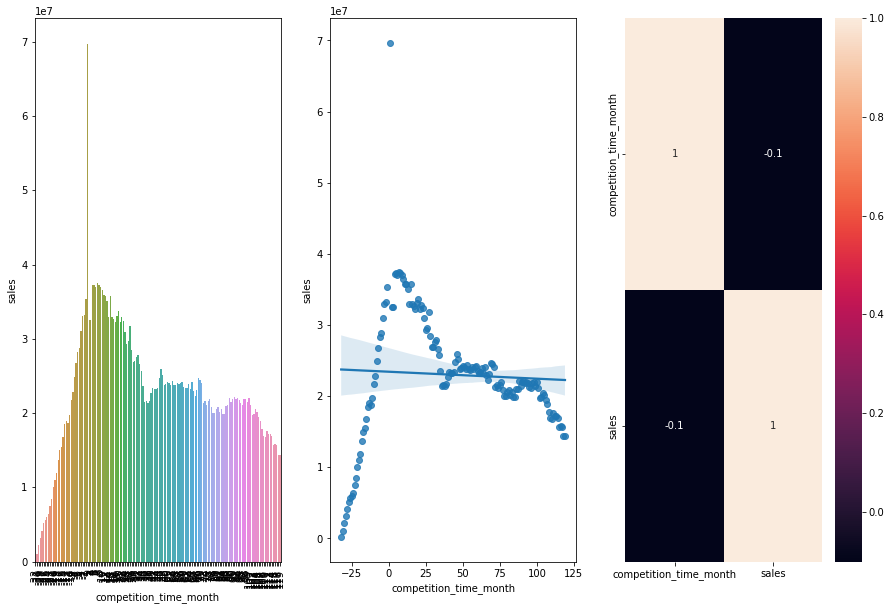

In [28]:
plt.figure(figsize=(15,10));

plt.subplot( 1,3,1)
aux6 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux7 = aux6[(aux6['competition_time_month'] < 120) & (aux6['competition_time_month'] != 0)];
sns.barplot(x='competition_time_month', y='sales', data=aux7);
plt.xticks( rotation=90);

plt.subplot( 1,3,2)
sns.regplot( x='competition_time_month', y='sales', data=aux7);

plt.subplot( 1,3,3)
sns.heatmap(aux6.corr(method='pearson'), annot=True);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoção ativas por mais tempo vendem menos, depois de um certo periodo de promoção

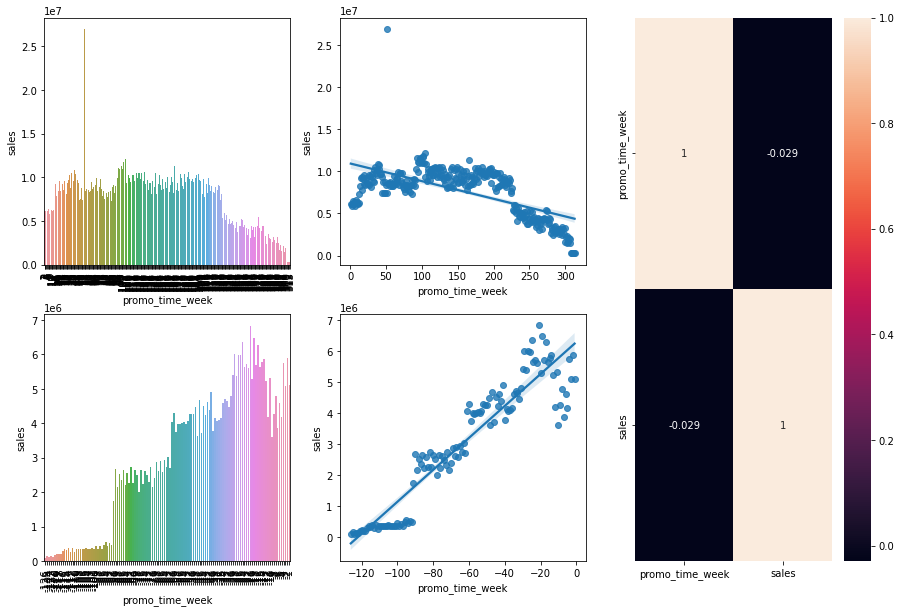

In [29]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=(15,10));

grid = gds.GridSpec(2,3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y= 'sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y= 'sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y= 'sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1] )
sns.regplot( x='promo_time_week', y= 'sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>



#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consectivas vendem menos

In [30]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


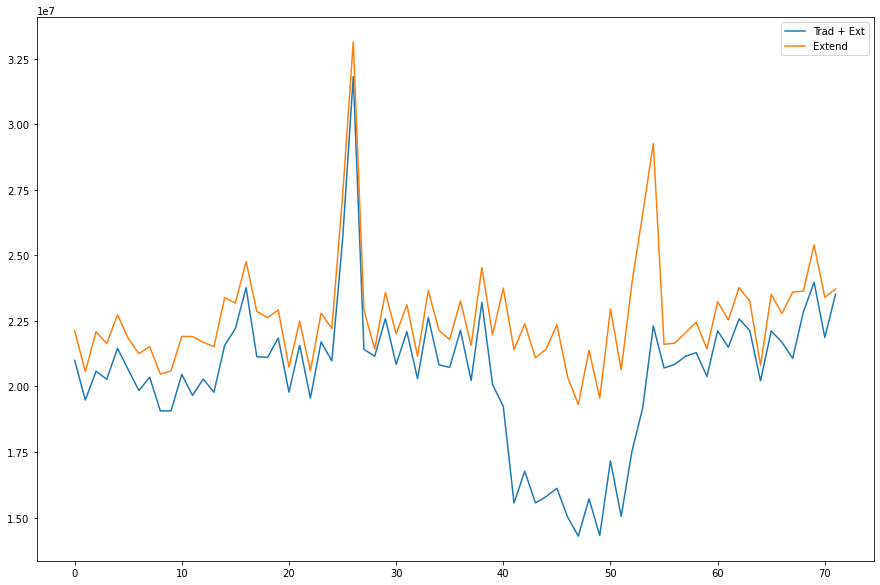

In [31]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,10))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax, figsize=(15,10))

ax.legend(labels=['Trad + Ext', 'Extend']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA**  

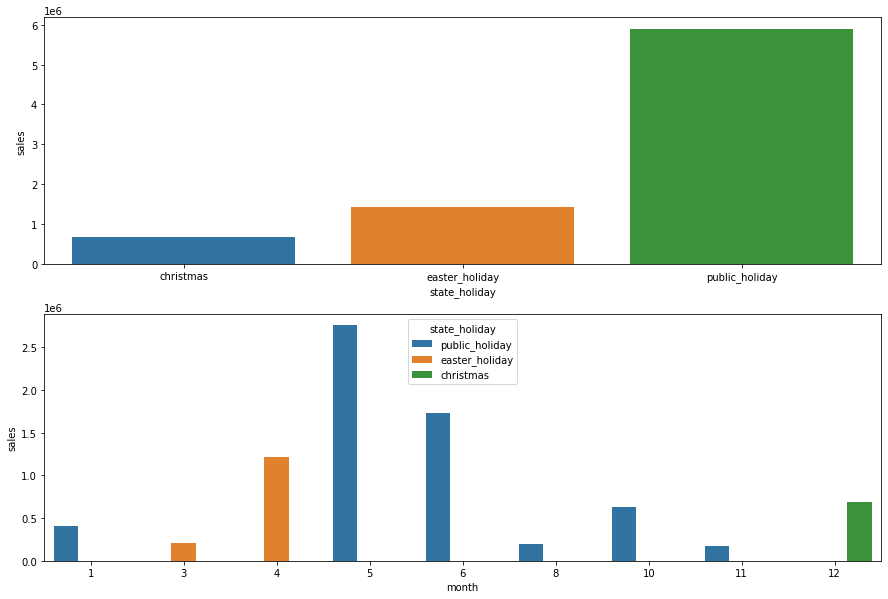

In [32]:
plt.figure(figsize=(15,10));
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(2,1,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y= 'sales', data=aux1);

plt.subplot(2,1,2)
aux2 = aux[[ 'month', 'state_holiday', 'sales']].groupby(['month', 'state_holiday']).sum().reset_index()
sns.barplot( x='month', y= 'sales', hue='state_holiday', data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA**


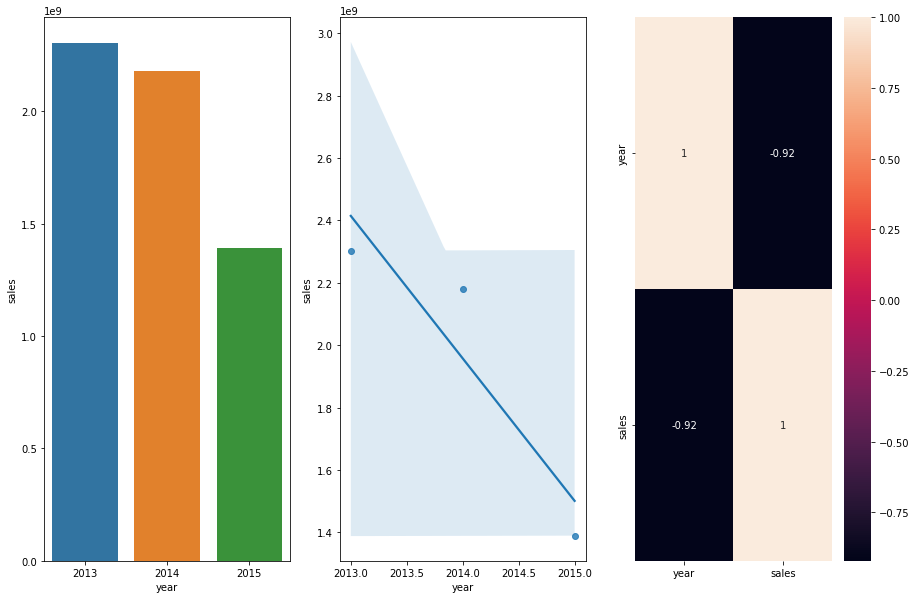

In [33]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(15,10))

plt.subplot( 1,3,1 )
sns.barplot( x='year', y= 'sales', data=aux1);

plt.subplot( 1,3,2 )
sns.regplot( x='year', y= 'sales', data=aux1);

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**



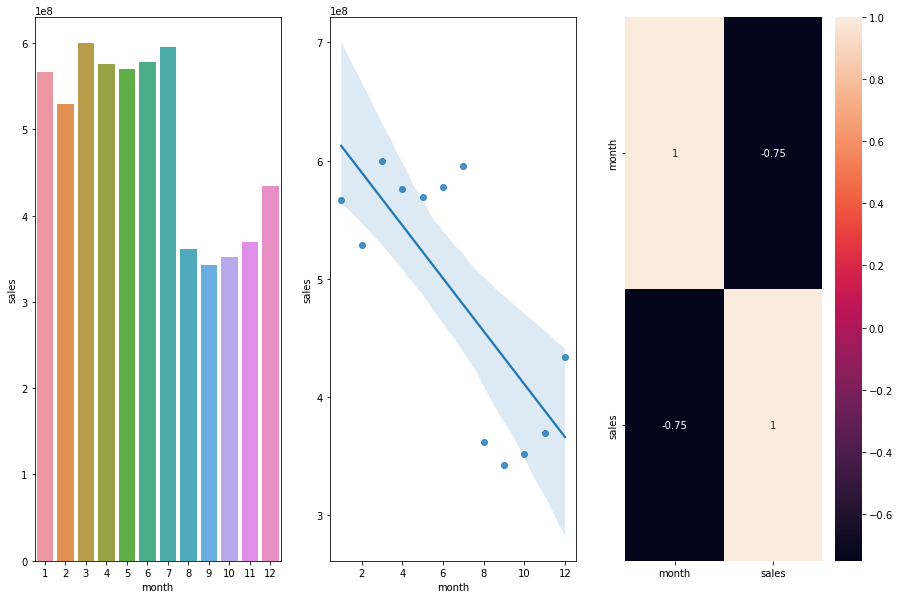

In [34]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize=(15,10))

plt.subplot( 1,3,1 )
sns.barplot( x='month', y= 'sales', data=aux1);

plt.subplot( 1,3,2 )
sns.regplot( x='month', y= 'sales', data=aux1);

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### **H10.** Lojas deveriam vender mais depois do dia 10 cada mês.
**VERDADEIRA**



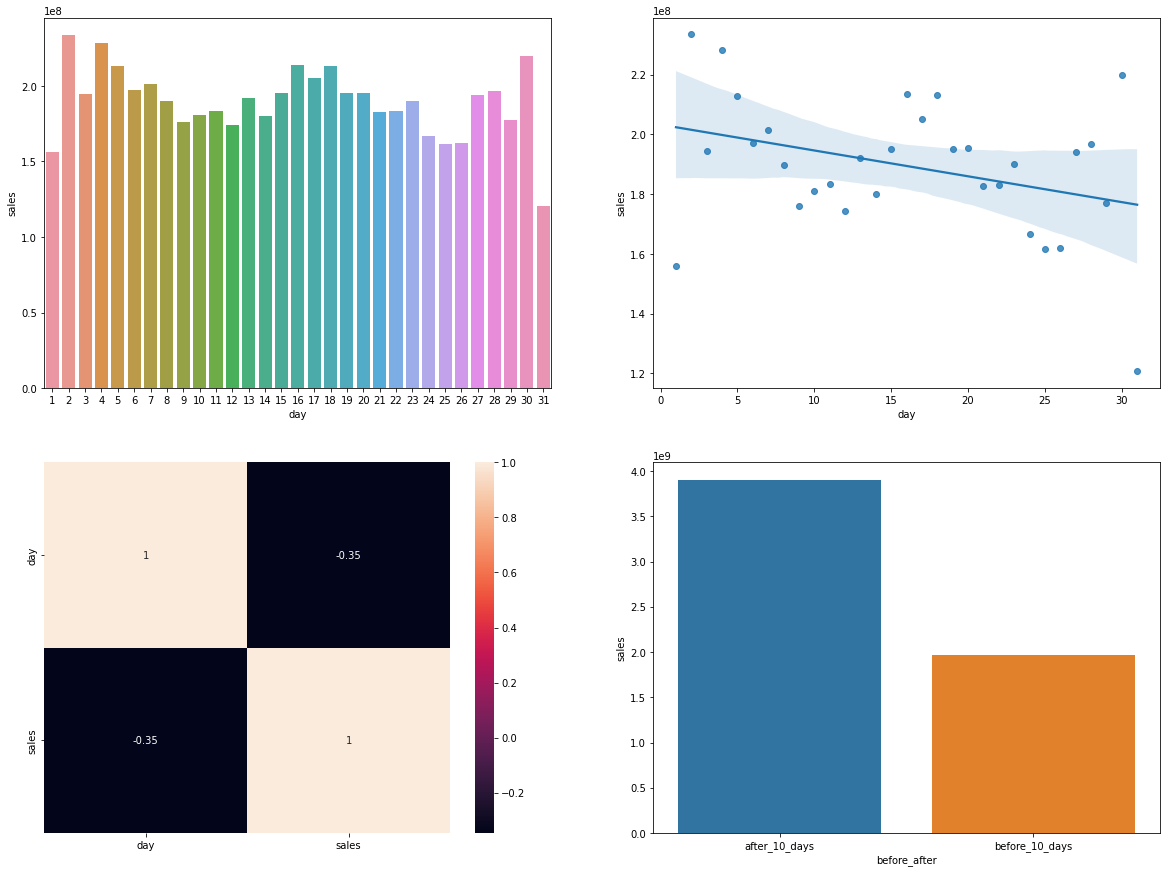

In [35]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize=(20,15))

plt.subplot( 2,2,1 )
sns.barplot( x='day', y= 'sales', data=aux1);

plt.subplot( 2,2,2 )
sns.regplot( x='day', y= 'sales', data=aux1);

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2,2,4)
sns.barplot( x='before_after', y='sales', data= aux2);

#### **H11.** Lojas deveriam vender menos aos finais da semana.
**VERDADEIRA**


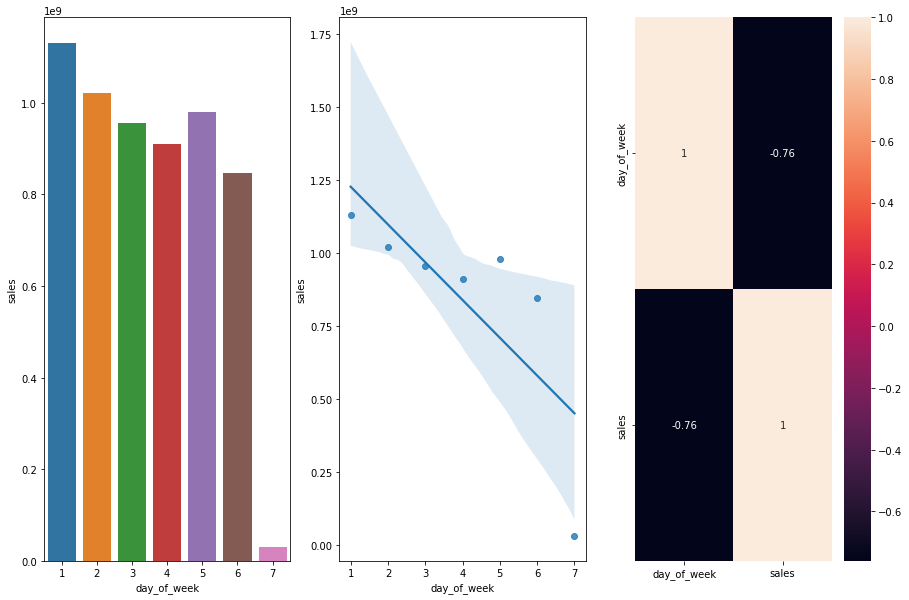

In [36]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize=(15,10))

plt.subplot( 1,3,1 )
sns.barplot( x='day_of_week', y= 'sales', data=aux1);

plt.subplot( 1,3,2 )
sns.regplot( x='day_of_week', y= 'sales', data=aux1);

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**

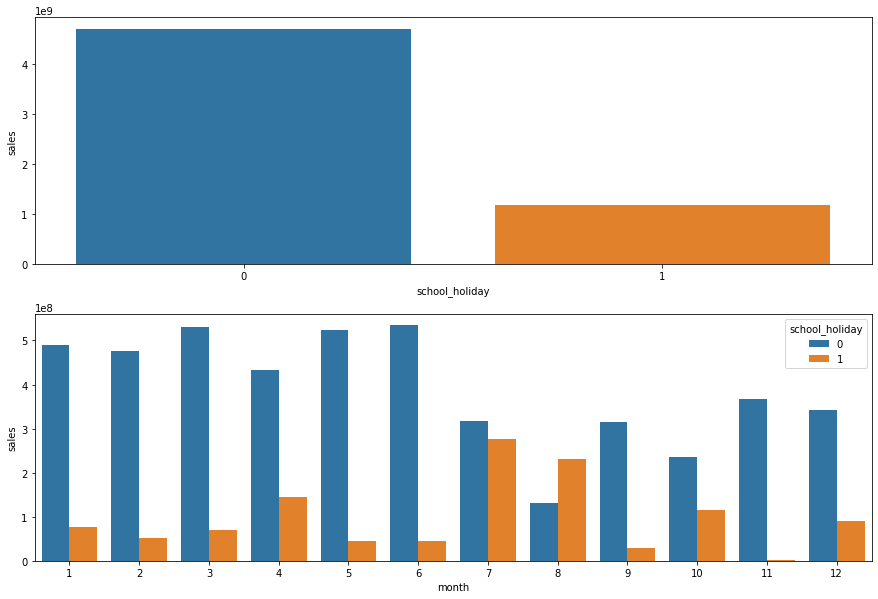

In [37]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.figure(figsize=(15,10))

plt.subplot( 2,1,1 )
sns.barplot( x='school_holiday', y= 'sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby([ 'month', 'school_holiday']).sum().reset_index()
plt.subplot( 2,1,2 )
sns.barplot( x='month', y= 'sales', hue='school_holiday', data=aux2);

#plt.subplot( 1,3,3 )
#sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### 4.2.1 Resumo das Hipoteses

In [38]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Media'],
        ['H3', 'Falsa', 'Media'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Media'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
        ]
print( tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3 Análise Multivariada

#### 4.3.1 Numerical Attributes

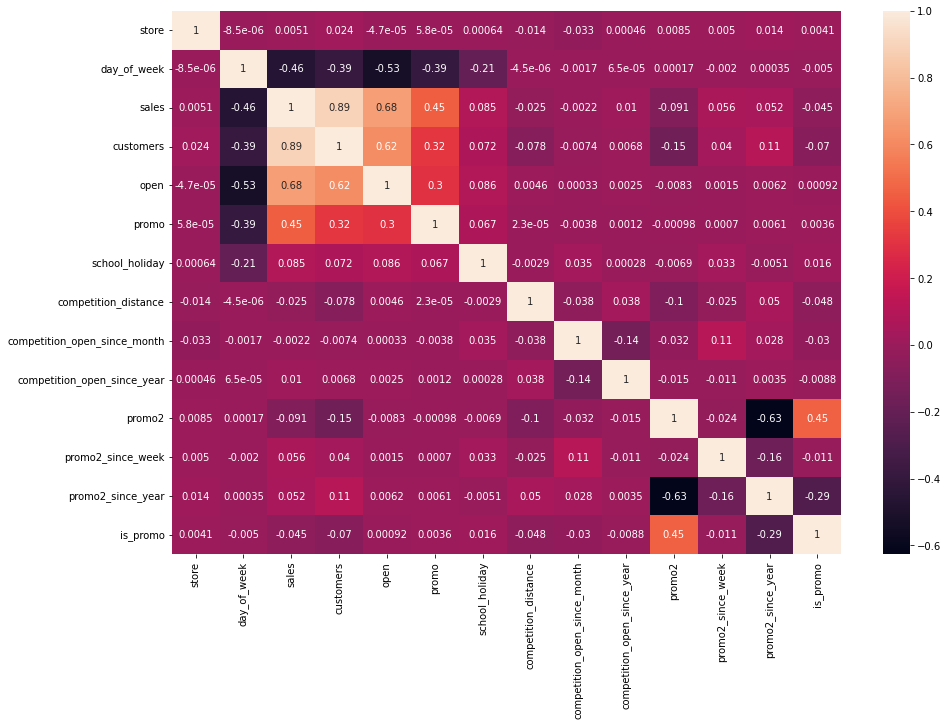

In [39]:
plt.figure(figsize=(15,10))
correlation = num_att.corr(method='pearson')
sns.heatmap( correlation, annot=True);

#### 4.3.2 Category Attributes

In [40]:
def cramer_v( x,y ):
    cm = pd.crosstab( x,y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2/n)/(min(k-1, r-1)))

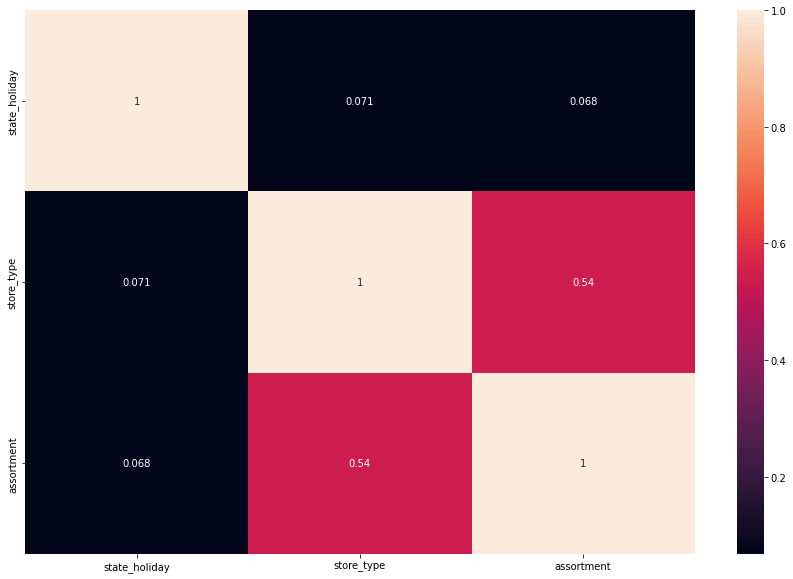

In [41]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate creamer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({ 'state_holiday': [a1,a2,a3],
                    'store_type': [a4,a5,a6],
                    'assortment': [a7,a8,a9]
                })

d = d.set_index(d.columns)

plt.figure(figsize=(15,10))
sns.heatmap( d, annot=True);

## 5.0 Passo 05 - Data Preparation

In [42]:
df5 = df4.copy()

### 5.1 Normalização

### 5.2 Rescaling

In [43]:
# variaveis normais
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

### 5.3 Transformação

#### 5.3.1 Encoding

In [44]:
# utilizado o One hot pois tem o estado de feriado e o estado de não feriado
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# por não possuir uma ordem sera utilizado o label
# store_type
le =LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])

# por ter uma ordem fazer o ordinal 
# assortment
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

#### 5.3.2 Response Variable Transformation

In [45]:
df5['sales'] = np.log1p( df5['sales'])

#### 5.3.3 Nature Transformation

In [46]:
# variaveis ciclicas
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2.*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2.*np.pi/7)))


In [47]:
df5.head(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
5,6,5,2015-07-31,8.639765,1,1,0,1,-0.325806,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
6,7,5,2015-07-31,9.638545,1,1,0,3,3.495161,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
7,8,5,2015-07-31,9.046998,1,1,0,1,0.837097,10,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
8,9,5,2015-07-31,9.055556,1,1,0,3,-0.048387,8,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
9,10,5,2015-07-31,8.879890,1,1,0,1,0.133871,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


## 6.0 Passo 06 - Feature Selection

In [48]:
df6 = df5.copy()

### 6.1 Split dataframe into training and test dataset

In [49]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [50]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [76]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min()))
print( 'Training Max Date: {}'.format( x_train['date'].max()))

print( '\nTest Min Date: {}'.format( x_test['date'].min()))
print( 'Test Min Date: {}'.format( x_test['date'].min()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-06-19 00:00:00


### 6.2 Boruta as feature selector 

In [52]:
# training and test dataset from boruta
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs= -1)

########## define boruta ###############
#boruta = BorutaPy(rf, n_estimators='auto', verbose= 2, random_state = 42).fit( x_train_n, y_train_n)

#### 6.2.1 Best features from boruta

In [53]:
#cols_selected = boruta.support_.tolist()

######### best features #############
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

########## not selected #########
#cols_not_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta))

### 6.3 Manual features selection

In [71]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment', 
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year', 
    'promo2', 
    'promo2_since_week',
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week',
    'month_sin', 
    'month_cos', 
    'day_sin',
    'day_cos', 
    'week_of_year_sin', 
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_final = cols_selected_boruta + feat_to_add
#cols_selected_boruta.extend( feat_to_add)

In [72]:
cols_final

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

## 7.0 Passo 07 - Machine Learning Modelling

In [78]:
x_train1 = x_train[cols_selected_boruta]
x_test1 = x_test[cols_selected_boruta]

# Dataset for cross validation
x_training = x_train[cols_final]

### 7.1 Average Model

In [57]:
def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat))

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0])

In [79]:
aux1 = x_test1.copy()
aux1['sales'] = y_test.copy()

# predition
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns= {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


### 7.2 Linear Regression Model

In [80]:
# model 
lr = LinearRegression().fit(x_train1, y_train)

# prediction
yhat_lr = lr.predict(x_test1)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1893.578386,0.295754,2705.769561


#### 7.2.1 Linear Regression Model - Cross Validation

In [100]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose= False)
lr_result_cv

Start Date: 2014-11-20 00:00:00
End Date: 2015-01-01 00:00:00
Start Date: 2015-01-01 00:00:00
End Date: 2015-02-12 00:00:00
Start Date: 2015-02-12 00:00:00
End Date: 2015-03-26 00:00:00
Start Date: 2015-03-26 00:00:00
End Date: 2015-05-07 00:00:00
Start Date: 2015-05-07 00:00:00
End Date: 2015-06-18 00:00:00


,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,Linear Regression,2108.49 +/- 299.73,0.31 +/- 0.02,2986.51 +/- 474.67


### 7.3 Linear Regression Regularized Model

In [60]:
# model 
lrr = Lasso( alpha= 0.01).fit(x_train1, y_train)

# prediction
yhat_lrr = lrr.predict(x_test1)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1906.839269,0.29104,2763.909115


#### 7.3.1 Lasso Model - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose= False)
lrr_result_cv

Start Date: 2014-11-20 00:00:00
End Date: 2015-01-01 00:00:00
Start Date: 2015-01-01 00:00:00
End Date: 2015-02-12 00:00:00
Start Date: 2015-02-12 00:00:00
End Date: 2015-03-26 00:00:00
Start Date: 2015-03-26 00:00:00
End Date: 2015-05-07 00:00:00
Start Date: 2015-05-07 00:00:00
End Date: 2015-06-18 00:00:00


,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,Linear Regression,2108.49 +/- 299.73,0.31 +/- 0.02,2986.51 +/- 474.67


### 7.4 Random Forest Regressor

In [ ]:
# model 
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42).fit(x_train1, y_train)

# prediction
#yhat_rf = rf.predict(x_test1)

# performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

#### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose= False)
rf_result_cv

Start Date: 2014-11-20 00:00:00
End Date: 2015-01-01 00:00:00
Start Date: 2015-01-01 00:00:00
End Date: 2015-02-12 00:00:00
Start Date: 2015-02-12 00:00:00
End Date: 2015-03-26 00:00:00
Start Date: 2015-03-26 00:00:00
End Date: 2015-05-07 00:00:00
Start Date: 2015-05-07 00:00:00
End Date: 2015-06-18 00:00:00


,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,Linear Regression,2108.49 +/- 299.73,0.31 +/- 0.02,2986.51 +/- 474.67


### 7.5 XGBoost Regressor

In [ ]:
# model
#model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                            n_estimators= 100,
                            eta = 0.01,
                            max_depth= 10,
                            subsample = 0.7,
                            colsample_bytree = 0.09).fit(x_train1, y_train)

# prediction
#yhat_xgb = model_xgb.predict(x_test1)

# performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

#### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose= True)
xgb_result_cv

Start Date: 2014-11-20 00:00:00
End Date: 2015-01-01 00:00:00
Start Date: 2015-01-01 00:00:00
End Date: 2015-02-12 00:00:00
Start Date: 2015-02-12 00:00:00
End Date: 2015-03-26 00:00:00
Start Date: 2015-03-26 00:00:00
End Date: 2015-05-07 00:00:00
Start Date: 2015-05-07 00:00:00
End Date: 2015-06-18 00:00:00


,Model Name,MAE Mean,MAPE Mean,RMSE Mean
0,Linear Regression,2108.49 +/- 299.73,0.31 +/- 0.02,2986.51 +/- 474.67


### 7.6 Compare Model's Performance

In [ ]:
#modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

In [102]:
#modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE')

### 7.7 Cross- Validation

In [101]:
def cross_validation ( x_training, kfold, model_name, model, verbose= False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range(1, kfold+1)):
        if verbose:
            print( '\nK-Fold: {}'.format( k))
        
        # start and end date for validation
        start_date = x_training['date'].max() - datetime.timedelta( days= k*6*7)
        end_date = x_training['date'].max() - datetime.timedelta( days= (k-1)*6*7)
      

        # filtering data
        training = x_training[(x_training['date'] < start_date)]
        validation = x_training[(x_training['date'] >= start_date) & (x_training['date'] <= end_date)]
        
        # training and validation data
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        # append
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE Mean': np.round( np.mean( mae_list), 2).astype( str) + ' +/-  ' + np.round( np.std( mae_list), 2).astype( str),
                            'MAPE Mean': np.round( np.mean( mape_list), 2).astype( str) + ' +/-  ' + np.round( np.std( mape_list), 2).astype( str),
                            'RMSE Mean': np.round( np.mean( rmse_list), 2).astype( str) + ' +/-  ' + np.round( np.std( rmse_list), 2).astype( str)}, index=[0])


## 8.0 Passo 08 - Fine Tuning

### 8.1 Random Search

In [ ]:
param = {'n_estimators': [1000, 2000, 3000, 4000, 5000],
          'eta': [0.01, 0.02, 0.03, 0.04, 0.05],
          'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
          'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]}

max_eval = 10          

In [ ]:
final_result = pd.DataFrame()

for i in range( max_eval):
    # choose random parameters
    hp = { k : random.sample( v, 1 )[0] for k, v in param.items()}
    print( '\nHyperparameters: {}'.format( hp))

    # model
    model = xgb.XGBRegressor( objective = 'reg:squarederror',
                            n_estimators= hp['n_estimators'],
                            eta = hp['eta'],
                            max_depth= hp['max_depth'],
                            min_child_weight= hp['min_child_weight'],
                            subsample = hp['subsample'],
                            colsample_bytree = hp['colsample_bytree'])

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model, verbose= False)
    final_result = final_result.append( result)

final_result.sort_values('RMSE Mean')

### 8.2 Final Model

In [ ]:
param_tuned = {'n_estimators': ,
          'eta': ,
          'max_depth': ,
          'min_child_weight': ,
          'subsample': ,
          'colsample_bytree': }
          

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                                    n_estimators= param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth= param_tuned['max_depth'],
                                    min_child_weight= param_tuned['min_child_weight'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree']).fit(x_train1, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test1)

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned